# Opt algorithm

前章では様々な事例に対して、 構造最適化を適用してみました。<br/>
本章では、構造最適化の際に適用を行った局所最適化アルゴリズムについて学んでいきます。

## アルゴリズムの種類

局所最適化アルゴリズムとして、ASEではMolecular Dynamics (MD)に似た振る舞いで最適化を行う `FIRE` や、2次関数近似をおこなって最適化を行う `BFGS`, `LBFGS`, `BFGSLineSearch`=`QuasiNewton`, `LBFGSLineSearch`法などが提供されています。

 - https://wiki.fysik.dtu.dk/ase/ase/optimize.html
 
|  アルゴリズム  | グループ | 特徴 |
| ---- | ---- | ---- |
| MDMin | MD-like  | MDを行うが、運動量とForceの内積が負になると運動量を0にリセットする |
| FIRE　 |  MD-like  | MDを行うが、様々な追加の工夫を入れて高速かつ頑健にしたもの |
| BFGS  | 準Newton法  | 最適化のトラジェクトリからヘシアンを近似し、近似ヘシアンを用いてNewton法のアルゴリズムを実行 |
| LBFGS  | 準Newton法  | BFGS法を高速・低メモリで動くようにしたもの |
| BFGSLineSearch  | 準Newton法  | BFGSで最適化のステップの方向を決定し、ステップの大きさはLineSearchで決定 |
| LBFGSLineSearch  | 準Newton法  | LBFGSで最適化のステップの方向を決定し、ステップの大きさはLineSearchで決定 |


MDMinはハイパーパラメーター依存性が大きく、構造最適化に失敗することも多いためベンチマークから除外し、他のOptimizerを見ていきます。

### FIRE
FIREでは基本的にMDを行いますが、高速に収束するように様々な工夫が加えられています。

### ニュートン法
ニュートン法ではヘシアンと勾配を用いて次のステップを決定します。ニュートン法は二次収束する手法であり、ポテンシャルが二次関数に近い時（極小点に近い時）真の解に二乗の速度で近づいていき非常に高速です。
ヘシアンを $H$、勾配を $\vec{g}$ として、次の最適化ステップ $\vec{p}$ を以下の式で表現します。

$\vec{p} = - H^{-1} \vec{g}$

仮にポテンシャルが厳密に二次関数であれば1ステップで極小値に収束します。

### 準ニュートン法
ヘシアンの評価は非常に重い（例えば数値計算なら6N回Forceを計算して求めることが出来る）ため、ヘシアンを計算している時間を使って構造最適化を進める方が有意義であることが良くあります。  
そこで、最適化のトラジェクトリを使って短時間でヘシアンを近似するのが準ニュートン法です。  
ヘシアンが厳密でないためNewton法ほど少ないステップ数で収束するというわけにはいきませんが、それでもかなり高速に収束します。

### BFGS
BFGS法は準ニュートン法の中でも最も標準的に使われているヘシアン近似方法です。  
他にも SR1法やDFP法等様々な方法が知られていますが、ASEではBFGS法が実装されています。

### LBFGS
BFGS法の欠点として、最適化した変数の次元の大きさの行列を格納し行列ベクトル積を計算しないといけないというものがあります。  
これは空間計算量が次元 $N$ に対して $O(N^2)$ 、時間計算量も $O(N^2)$ となり、多次元の関数を最適化するのに不向きです。  
そこで直近のいくつかのトラジェクトリの情報だけを用いてBFGS法とほとんど同じ結果になるように変形し、$O(N)$ の計算量でBFGSをほとんど再現できるようにしたのがLBFGS法です。    
PFPの計算量は $O(N)$ なので、BFGSのような $O(N^2)$ の手法を用いると原子数300程度からOptimizerでの計算時間が目立ってきますが、LBFGSだと原子数が増えてもOptimizerの計算時間は目立ってきません。  

### LineSearch
ポテンシャルが二次関数でない場合、ニュートン法は振動してしまうことがあります。また、準ニュートン法ではヘシアンが正確でないこともあり、適切なステップサイズを提示できないことがあります。  
このような場合でも最適化を収束させるため、LineSearchを行うと最適化が安定します。  
準ニュートン法で最適化の方向を決めた後、最適化のステップサイズに関してはその方向にエネルギーが十分小さくなるようなステップサイズをとることが望ましいです。このようなステップサイズを実際に何点か計算してみて決定するのがLineSearchです。  
BFGS等だとニュートン法の方法に従って計算した結果エネルギーが上がってしまったというようなケースがありえますが、BFGSLineSearchだとそのようなケースでも良いステップサイズを探索します。

## ベンチマーク

In [1]:
import os
from time import perf_counter
from typing import Optional, Type

import matplotlib.pyplot as plt
import pandas as pd
from ase import Atoms
from ase.build import bulk, molecule
from ase.calculators.calculator import Calculator
from ase.io import Trajectory
from ase.optimize import BFGS, FIRE, LBFGS, BFGSLineSearch, LBFGSLineSearch, MDMin
from ase.optimize.optimize import Optimizer
from tqdm.auto import tqdm

import pfp_api_client
from pfcc_extras.structure.ase_rdkit_converter import atoms_to_smiles, smiles_to_atoms
from pfcc_extras.visualize.view import view_ngl
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

In [2]:
calc = ASECalculator(Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0"))
calc_mol = ASECalculator(Estimator(calc_mode=EstimatorCalcMode.MOLECULE, model_version="v2.0.0"))
print(f"pfp_api_client: {pfp_api_client.__version__}")
print(calc.estimator.model_version)

pfp_api_client: 1.3.1
v2.0.0


### Force計算回数の比較

以下はCH3CHO分子の構造最適化を行う簡単な例です。<br/>
`molecule("CH3CHO")` で得られる構造は厳密な安定構造ではありませんが、かなり良い構造をしています。  
このような構造から開始した時には準ニュートン法を用いるとかなり少ない回数のPFP呼び出しで構造最適化を完了することが出来ます。  

### Force計算回数の比較

まずは構造最適化が完了するまでにForceを何回計算するかベンチマークをとってみましょう。  
ここではPtのバルクを乱数で動かした構造を初期値として、最適構造になるまでのForce計算回数を測定します。  

In [3]:
def get_force_calls(opt: Optimizer) -> int:
    """forceの呼び出し回数を取得する。LineSearchのあるOptimizerではforce_callsがForce評価回数を示し、LineSearchがないOptimizerではnstepsとForce評価回数が一致する。"""
    if isinstance(opt, (BFGSLineSearch, LBFGSLineSearch)):
        return opt.force_calls
    else:
        return opt.nsteps

In [4]:
os.makedirs("output", exist_ok=True)

In [5]:
atoms_0 = bulk("Pt") * (4, 4, 4)
atoms_0.rattle(stdev=0.1)

In [6]:
view_ngl(atoms_0)

In [7]:
force_calls = {}
for opt_class in tqdm([FIRE, BFGS, LBFGS, BFGSLineSearch, LBFGSLineSearch]):
    atoms = atoms_0.copy()
    atoms.calc = calc
    name = opt_class.__name__
    with opt_class(atoms, trajectory=f"output/{name}_ch3cho.traj", logfile=None) as opt:
        opt.run(fmax=0.05)
        force_calls[name] = [get_force_calls(opt)]

  0%|          | 0/5 [00:00<?, ?it/s]

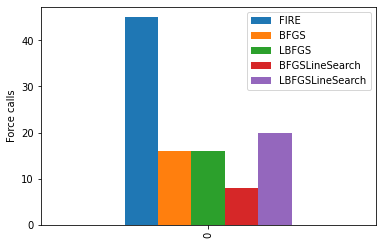

In [8]:
df = pd.DataFrame.from_dict(force_calls)
df.plot.bar()
plt.ylabel("Force calls")
plt.show()

FIREが抜きんでてForce評価回数が多く、BFGSとLBFGSは同じくらいとなりました。  
また、LineSearchのある手法もBFGSやLBFGSと同じくらいのForce評価回数となりました。

### 1ステップあたりの速度比較

次に同じそれぞれの最適化手法の1stepあたりの速度を比較してみます。

In [9]:
from ase.build import bulk

atoms = bulk("Fe") * (10, 5, 3)
atoms.rattle(stdev=0.2)
atoms.calc = calc

view_ngl(atoms)

In [10]:
def opt_benchmark(atoms: Atoms, calculator: Calculator, opt_class, logfile: Optional[str] = "-", steps: int = 10) -> float:
    _atoms = atoms.copy()
    _atoms.calc = calculator
    with opt_class(_atoms, logfile=logfile) as opt:
        start_time = perf_counter()
        opt.run(steps=steps)
        end_time = perf_counter()
        duration = end_time - start_time
        duration_per_force_calls = duration / get_force_calls(opt)
    return duration_per_force_calls

In [11]:
result_dict = {
    "n_atoms": [],
    "FIRE": [],
    "BFGS": [],
    "LBFGS": [],
    "BFGSLineSearch": [],
    "LBFGSLineSearch": [],
}


for i in range(1, 10):
    atoms = bulk("Fe") * (10, 10, i)
    atoms.rattle(stdev=0.2)
    n_atoms = atoms.get_global_number_of_atoms()
    result_dict["n_atoms"].append(n_atoms)
    print(f"----- n_atoms {n_atoms} -----")
    for opt_class in [FIRE, BFGS, LBFGS, BFGSLineSearch, LBFGSLineSearch]:
        name = opt_class.__name__
        print(f"Running {name}...")
        duration = opt_benchmark(atoms, calc, opt_class=opt_class, logfile=None, steps=10)
        print(f"Done in {duration:.2f} sec.")
        result_dict[name].append(duration)

----- n_atoms 100 -----
Running FIRE...
Done in 0.06 sec.
Running BFGS...
Done in 0.09 sec.
Running LBFGS...
Done in 0.06 sec.
Running BFGSLineSearch...
Done in 0.07 sec.
Running LBFGSLineSearch...
Done in 0.06 sec.
----- n_atoms 200 -----
Running FIRE...
Done in 0.09 sec.
Running BFGS...
Done in 0.19 sec.
Running LBFGS...
Done in 0.09 sec.
Running BFGSLineSearch...
Done in 0.13 sec.
Running LBFGSLineSearch...
Done in 0.09 sec.
----- n_atoms 300 -----
Running FIRE...
Done in 0.12 sec.
Running BFGS...
Done in 0.32 sec.
Running LBFGS...
Done in 0.12 sec.
Running BFGSLineSearch...
Done in 0.19 sec.
Running LBFGSLineSearch...
Done in 0.12 sec.
----- n_atoms 400 -----
Running FIRE...
Done in 0.15 sec.
Running BFGS...
Done in 0.53 sec.
Running LBFGS...
Done in 0.15 sec.
Running BFGSLineSearch...
Done in 0.30 sec.
Running LBFGSLineSearch...
Done in 0.15 sec.
----- n_atoms 500 -----
Running FIRE...
Done in 0.19 sec.
Running BFGS...
Done in 0.92 sec.
Running LBFGS...
Done in 0.18 sec.
Running B

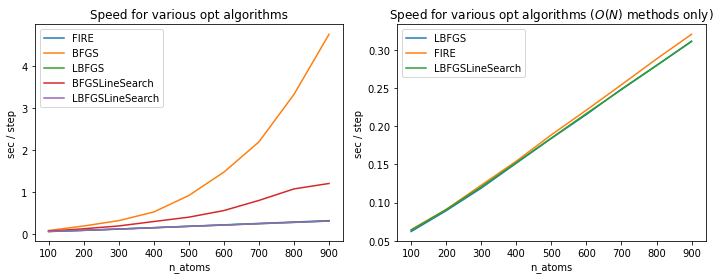

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
df = pd.DataFrame(result_dict)
df = df.set_index("n_atoms")
df.plot(ax=axes[0])
axes[0].set_title("Speed for various opt algorithms")
df[["LBFGS", "FIRE", "LBFGSLineSearch"]].plot(ax=axes[1])
axes[1].set_title("Speed for various opt algorithms ($O(N)$ methods only)")
for ax in axes:
    ax.set_ylabel("sec / step")
fig.savefig("output/opt_benchmark.png")
plt.show(fig)

BFGSやBFGSLineSearchでは原子数が多くなるにつれて1ステップあたりの計算時間が長くなってしまっています。  

ASEに実装されているBFGS法ではHessianの逆行列を求める際に固有値分解を毎ステップごとに行います。  
Hessianは縦横それぞれ原子数をNとして3Nの大きさをもっており、固有値分解の計算量は $O(N^3)$ であるため、ASEのBFGS法は原子数の3乗のオーダーで急速に遅くなっていきます。 

また、BFGSLineSearchではHessianの固有値分解を行うことなく、Hessianの逆行列を直接近似します。このため、行列ベクトル積が律速になり $O(N^2)$ とBFGSよりは速くなります。  
しかし、原子数が多い時には $O(N)$ で動作するLBFGSやLBFGS、FIREよりはずっと遅くなります。 

## 最適化アルゴリズムの使い分け

これまでに、FIREは他の手法よりもForce呼び出し回数が多く、BFGSやBFGSLineSearchは原子数が多くなるとForceの評価よりもOptimizerの内部ルーチンの方が律速になることを見てきました。  
ではどういった場合でもLBFGSとLBFGSLineSearchを用いると良いのでしょうか？  
これからそれらのアルゴリズムでもうまくいかない例もあることを見ていきましょう。  

### LBFGSやBFGSがうまくいかない例


次の例を見てみましょう。
この例ではとても単純なポテンシャルである Lennard-Jones (LJ) potentialを用いて、その安定点から離れたところを初期値として構造最適化を行っています。
 - https://wiki.fysik.dtu.dk/ase/ase/calculators/others.html#lennard-jones

LJ potential は次式で表される形をしており、以下のような形をしています。

$$ \phi (r) = 4 \epsilon \bigg\{ \left( \frac{\sigma}{r} \right) ^{12} -  \left( \frac{\sigma}{r} \right) ^{6} \bigg\} $$

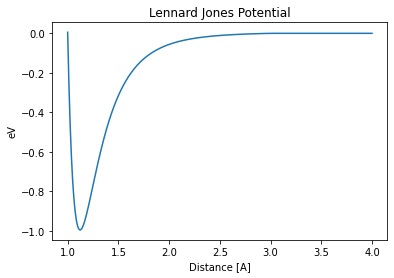

In [13]:
from ase.calculators.lj import LennardJones
import numpy as np


calc_lj = LennardJones()

dists = np.linspace(1.0, 4.0, 500)


E_pot_list = []
for d in dists:
    atoms = Atoms("Ar2", [[0, 0, 0], [d, 0, 0]])
    atoms.calc = calc_lj
    E_pot = atoms.get_potential_energy()
    E_pot_list.append(E_pot)

plt.plot(dists, E_pot_list)
plt.title("Lennard Jones Potential")
plt.ylabel("eV")
plt.xlabel("Distance [A]")
plt.show()

この単純なPotential の形でDistanceを安定点である1.12A から離れたところからスタートし構造最適化をしてみましょう。

In [14]:
def lennard_jones_trajectory(opt_class: Type[Optimizer], d0: float):
    name = opt_class.__name__
    trajectory_path = f"output/Ar_{name}.traj"

    atoms = Atoms("Ar2", [[0, 0, 0], [d0, 0, 0]])
    atoms.calc = calc_lj

    opt = opt_class(atoms, trajectory=trajectory_path)
    opt.run()

    distance_list = []
    energy_list = []
    for atoms in Trajectory(trajectory_path):
        energy_list.append(atoms.get_potential_energy())
        distance_list.append(atoms.get_distance(0, 1))

    print("Distance in opt trajectory: ", distance_list)

    plt.plot(dists, E_pot_list)
    plt.plot(distance_list, energy_list, marker="x")
    plt.title(f"Lennard Jones Potential: {name} opt")
    plt.ylim(-1.0, 0)
    plt.ylabel("eV")
    plt.xlabel("Distance [A]")
    plt.show()

まずはFIREを行った場合です。安定して最適値1.12A にたどり着くことが出来ています。

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 05:50:32       -0.314857*       1.1580
FIRE:    1 05:50:32       -0.342894*       1.2644
FIRE:    2 05:50:32       -0.410024*       1.5124
FIRE:    3 05:50:32       -0.546744*       1.9683
FIRE:    4 05:50:32       -0.812180*       2.3839
FIRE:    5 05:50:32       -0.862167*       5.5858
FIRE:    6 05:50:32       -0.966377*       2.1492
FIRE:    7 05:50:32       -0.991817*       0.5223
FIRE:    8 05:50:32       -0.992148*       0.4913
FIRE:    9 05:50:32       -0.992732*       0.4299
FIRE:   10 05:50:32       -0.993427*       0.3400
FIRE:   11 05:50:32       -0.994057*       0.2245
FIRE:   12 05:50:32       -0.994451*       0.0884
FIRE:   13 05:50:32       -0.994489*       0.0606
FIRE:   14 05:50:32       -0.994490*       0.0595
FIRE:   15 05:50:32       -0.994492*       0.0573
FIRE:   16 05:50:32       -0.994495*       0.0541
FIRE:   17 05:50:32       -0.994499*       0.0499
Di

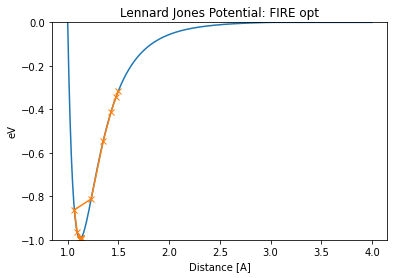

In [15]:
lennard_jones_trajectory(FIRE, 1.5)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 05:50:33       -0.697220*       2.3246
FIRE:    1 05:50:33       -0.807702*       2.3874
FIRE:    2 05:50:33       -0.987241*       0.8220
FIRE:    3 05:50:33       -0.520102*      13.5704
FIRE:    4 05:50:33       -0.971689*       1.9036
FIRE:    5 05:50:33       -0.939109*       1.8400
FIRE:    6 05:50:33       -0.943288*       1.7937
FIRE:    7 05:50:33       -0.951214*       1.6946
FIRE:    8 05:50:33       -0.961964*       1.5294
FIRE:    9 05:50:33       -0.974030*       1.2780
FIRE:   10 05:50:33       -0.985244*       0.9149
FIRE:   11 05:50:33       -0.992867*       0.4142
FIRE:   12 05:50:33       -0.994043*       0.2396
FIRE:   13 05:50:33       -0.994061*       0.2350
FIRE:   14 05:50:33       -0.994095*       0.2259
FIRE:   15 05:50:33       -0.994143*       0.2125
FIRE:   16 05:50:33       -0.994201*       0.1951
FIRE:   17 05:50:33       -0.994265*       0.1741
FI

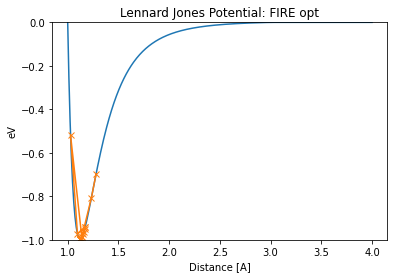

In [16]:
lennard_jones_trajectory(FIRE, 1.28)

BFGS法を1.5Aから開始した場合、特定のstepではあまりにも大きくジャンプしてしまい、安定点を大きく飛び越えるような不安定な挙動になっていることがわかります。<br/>
(1.18A --> 0.78Aにジャンプしているようなところです。)<br/>
このように、最適値1.12A にたどり着くまでに、この単純な例でも大きく振動しまいます。<br/>
これは2次の近似を行う手法では、関数曲面が2次関数と異なる場合に、その極小値の見積もりが大きくはずれてしまうために起こります。

      Step     Time          Energy         fmax
BFGS:    0 05:50:34       -0.314857        1.1580
BFGS:    1 05:50:34       -0.355681        1.3124
BFGS:    2 05:50:34       -0.916039        2.0410
BFGS:    3 05:50:34       55.304434      974.4875
BFGS:    4 05:50:34       -0.917740        2.0288
BFGS:    5 05:50:34       -0.919418        2.0163
BFGS:    6 05:50:34       -0.747080        8.5176
BFGS:    7 05:50:34       -0.965068        1.4729
BFGS:    8 05:50:34       -0.984660        0.9397
BFGS:    9 05:50:34       -0.992324        0.5286
BFGS:   10 05:50:34       -0.994444        0.0924
BFGS:   11 05:50:34       -0.994520        0.0073
Distance in opt trajectory:  [1.5, 1.4669134619701096, 1.1856710148074785, 0.7856710148074794, 1.1848349876531552, 1.1840057048694352, 1.0494144415980853, 1.1582431525834571, 1.1421985974452118, 1.1139254943723882, 1.1241042745909056, 1.122589482834374]


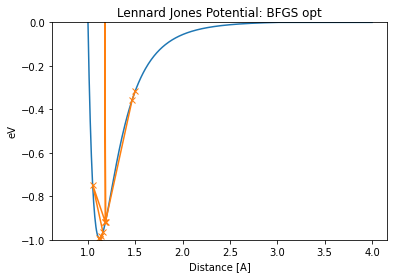

In [17]:
lennard_jones_trajectory(BFGS, 1.5)

同じことがLBFGS法でも起こります。  
このような振動が多原子系で起こった場合、長い間最適化が終了しないような場合もあります。

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:50:35       -0.697220*       2.3246
LBFGS:    1 05:50:35       -0.854683*       2.3149
LBFGS:    2 05:50:35       33.771592*     599.7519
LBFGS:    3 05:50:35       -0.858237*       2.3057
LBFGS:    4 05:50:35       -0.861748*       2.2959
LBFGS:    5 05:50:36       17.305333*     318.4918
LBFGS:    6 05:50:36       -0.867638*       2.2781
LBFGS:    7 05:50:36       -0.873395*       2.2589
LBFGS:    8 05:50:36        5.604073*     121.1548
LBFGS:    9 05:50:36       -0.885566*       2.2113
LBFGS:   10 05:50:36       -0.897001*       2.1571
LBFGS:   11 05:50:36        0.369118*      30.7872
LBFGS:   12 05:50:36       -0.925197*       1.9707
LBFGS:   13 05:50:36       -0.947015*       1.7491
LBFGS:   14 05:50:36       -0.915603*       4.0090
LBFGS:   15 05:50:36       -0.985429*       0.9069
LBFGS:   16 05:50:36       -0.993163*       0.3771
LBFGS:   17 05:50:36       -0.9944

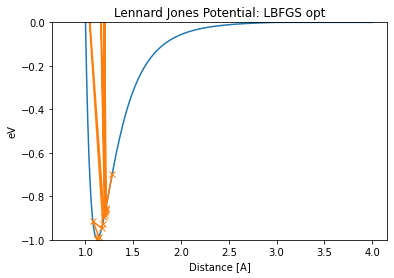

In [18]:
lennard_jones_trajectory(LBFGS, 1.28)

このような振動が多原子系で起こった場合、本当にいつまでたっても最適化が終了しないような場合もあります。

また、他にも初期値が安定点から離れたところからスタートした場合に正しく安定点にたどり着けていないケースも有ります。<br/>
これは、Hessianの初期化がうまく行かないなどの理由で起きていると考えられます。

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:50:37       -0.314857*       1.1580
LBFGS:    1 05:50:37       -0.355681*       1.3124
LBFGS:    2 05:50:37       -0.129756*       0.4473
LBFGS:    3 05:50:37       -0.079409*       0.2630
LBFGS:    4 05:50:37       -0.040472*       0.1297
LBFGS:    5 05:50:37       -0.021155*       0.0689
LBFGS:    6 05:50:37       -0.009646*       0.0357
Distance in opt trajectory:  [1.5, 1.4669134619701096, 1.748155909132741, 1.8935676545167726, 2.101103976550205, 2.302941039822042, 2.531922335240822]


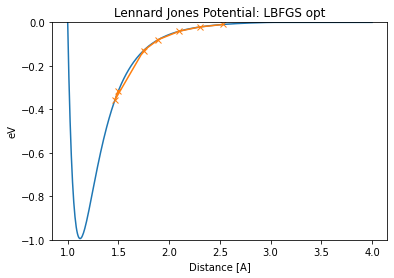

In [19]:
lennard_jones_trajectory(LBFGS, 1.50)

このようにBFGSやLBFGSがうまくいかない例であっても、LineSearchを行うことで正しく収束させることが出来ます。  
LBFGSLineSearchはほとんどの場合において最良のOptimizerです。

                 Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGSLineSearch:    0 05:50:38       -0.314857*       1.1580
LBFGSLineSearch:    1 05:50:38       -0.994517*       0.0214
Distance in opt trajectory:  [1.5, 1.1220880716401869]


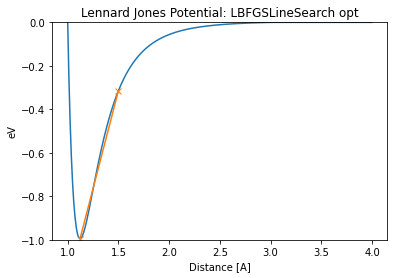

In [20]:
lennard_jones_trajectory(LBFGSLineSearch, 1.5)

LBFGSLineSearchでは1ステップで終了しているように見えますが、内部でLineSearchを行っている部分がステップにカウントされていないため、実際の計算数はもう少し多いです。</br>
BFGSLineSearchでは Step[FC]という表示がありますが、このFCが実際のフォース評価回数です。

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 05:50:39       -0.314857*       1.1580
BFGSLineSearch:    1[  5] 05:50:39       -0.994057*       0.2244
BFGSLineSearch:    2[  7] 05:50:39       -0.994520*       0.0054
Distance in opt trajectory:  [1.5, 1.1265420003736115, 1.1225561293552997]


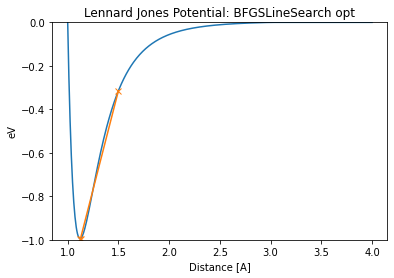

In [21]:
lennard_jones_trajectory(BFGSLineSearch, 1.5)

ここではBFGSやLBFGSがうまくいかない例があることを見てきました。
しかし、このような例であってもLBFGSLineSearchはうまくいっています。

ここまでの結論としては多くの場合においてLBFGSLineSearchが最良のOptimizerとなります。  
以下にLBFGSLineSearch以外のOptimizerの欠点を述べます。

- FIRE: 収束までのステップ数が長い
- BFGS: 原子数が多い時に計算時間がかかる。
- BFGSLineSearch: 原子数が多い時に計算時間がかかる。
- LBFGS: 振動したり、エネルギーが上がってしまう場合がある。

しかし、常にLBFGSLineSearchを使うとうまくいくかというと、現状残念ながら必ずしもそうではありません。

### LBFGSLineSearchが良くない例

LBFGSLineSearchは非常に完成度の高い手法であり、多くの場合はLBFGSLineSearchを使えばうまくいきます。  
しかし、稀にLBFGSLineSearchがうまくいかなくなってしまう例も存在します。  
例えば、fmaxを小さくして精密に構造最適化したい時に良くこのような例にあたります。  
例えばトルエンのメチル基の回転を最適化したい場合、fmax=0.001eV/A程度にしないと回転に関して極小値に到達しません。   
この例ではLineSearchがなかなか収束しなくなり1ステップに長い時間がかかるようになったり、エネルギーが下がらなくなったり、場合によってはLineSearchが破綻して `RuntimeError: LineSearch failed!` となってエラーになってしまう場合もあります。

In [22]:
atoms_0 = smiles_to_atoms("Cc1ccccc1")
tmp = atoms_0[7:10]
tmp.rotate([1.0, 0.0, 0.0], 15.0)
atoms_0.positions[7:10] = tmp.positions
atoms_0.calc = calc_mol

In [23]:
view_ngl(atoms_0, representations=["ball+stick"], h=600, w=600)

In [24]:
# Please set '-', if you want to see detailed logs.
logfile = None

steps = {}
images = []
for optimizer_class in (FIRE, LBFGS, LBFGSLineSearch):
    name = optimizer_class.__name__
    atoms = atoms_0.copy()
    atoms.calc = calc_mol
    with optimizer_class(atoms, logfile=logfile) as opt:
        try:
            print(f"{name} optimization starts.")
            opt.run(fmax=0.001, steps=200)
            print(f"Optimization finished without error. steps = {opt.nsteps}")
        finally:
            steps[name] = [get_force_calls(opt)]
            images.append(atoms.copy())

FIRE optimization starts.
Optimization finished without error. steps = 200
LBFGS optimization starts.
Optimization finished without error. steps = 80
LBFGSLineSearch optimization starts.


RuntimeError: LineSearch failed!

In [25]:
steps["index"] = "nsteps"
df = pd.DataFrame(steps)
df = df.set_index("index")
df

,FIRE,LBFGS,LBFGSLineSearch
index,,,
nsteps,200,80,354


この例ではLBFGSは収束しますが、FIREは収束しませんでした。

また、LBFGSLineSearchは後半に1ステップあたりにすごく長い時間がかかった上に収束せず、場合によっては  `RuntimeError: LineSearch failed!` というエラーが出ます。  
経験的に多くの場合はfmax=0.002eV/A 付近からLBFGSLineSearchが収束しにくくなりますが、  
もっとポテンシャルの形状が悪い場合はfmax=0.05に到達しないケースもあります。

ちなみに、このようにLBFGSLineSearchが進まなくなってしまった場合はLBFGSLineSearchを実行しなおすことで、うまくいくようになることがあります。（うまくいかない時もあります）  

In [26]:
with LBFGSLineSearch(atoms) as opt:
    opt.run(0.001)

                 Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGSLineSearch:    0 05:51:28      -72.184868*       0.0060
LBFGSLineSearch:    1 05:51:29      -72.184873*       0.0060
LBFGSLineSearch:    2 05:51:29      -72.184873*       0.0060
LBFGSLineSearch:    3 05:51:30      -72.184873*       0.0060
LBFGSLineSearch:    4 05:51:30      -72.184873*       0.0060
LBFGSLineSearch:    5 05:51:30      -72.184873*       0.0060
LBFGSLineSearch:    6 05:51:31      -72.184874*       0.0060
LBFGSLineSearch:    7 05:51:31      -72.184875*       0.0060
LBFGSLineSearch:    8 05:51:32      -72.184875*       0.0060
LBFGSLineSearch:    9 05:51:32      -72.184875*       0.0060
LBFGSLineSearch:   10 05:51:32      -72.184873*       0.0060
LBFGSLineSearch:   11 05:51:33      -72.184874*       0.0060
LBFGSLineSearch:   12 05:51:33      -72.184875*       0.0060
LBFGSLineSearch:   13 05:51:33      -72.184874*       0.0060
LBFGSLineSearch:   14 05:51:34      -

RuntimeError: LineSearch failed!

In [27]:
view_ngl(images, representations=["ball+stick"])

### 上記知見を踏まえた、最適化アルゴリズムの実装

LBFGSLineSearchは多くの場合最良のOptimizerですが、fmaxが小さいと非常に遅くなってしまうだけでなく、場合によってはエラーが出てしまうことがあります。  
FIREはLBFGSLineSearchと比べて遅いことが多いですが、多くの場合頑健に動作します。ただし、fmaxが小さいとなかなか収束しないことがあります。  
LBFGSはfmaxが小さくても収束しますが、Lennard-Jonesの例で見たように振動したりエネルギーが上がってしまうケースがあります。

ヒューリスティックな表現をすると、2次関数近似が良い近似となる安定点に近いところでは、収束性の良い2次のニュートン法を用いたいです。
ただし、LBFGSLineSearchが数値的に安定しないケースがあるためLBFGSを使いたいです。  
２次関数近似がよい近似とならない不安定な構造では、FIREやLBFGSLineSearchを使って頑健にエネルギーを落としたいです。  
しかし、LBFGSLineSearchが数値的に安定しないケースがどれくらのfmaxで起こるか予想しきれないため、
ハイスループット計算など、未知の物質に対して統一的に手法を適用する場合ではFIREのほうが安定に動作します。

ここまでの知見をまとめると、ヒューリスティックにうまくいきそうな最適化アルゴリズムとして、
 - 構造最適化の初期など、不安定な場所では、FIREを用いて勾配を下っていく。
 - ある程度安定点に達したら(Forceなどが小さな値になったら)LBFGS法を用いて高速に収束を試みる。

という方法がうまくいきそうです。

matlantis-features では、このようなアルゴリズムを `FIRELBFGS` Optimizer として実装をしています。

In [28]:
from matlantis_features.features.common.fire_lbfgs import FIRELBFGS

まずはLBFGSLineSearchが破綻した例であるトルエンのメチル基の回転を見てみましょう。  
このような例でも破綻することなく、LBFGSよりは遅いがFIREよりはずっと速く、頑健に収束しています。

In [29]:
atoms_0 = smiles_to_atoms("Cc1ccccc1")
tmp = atoms_0[7:10]
tmp.rotate([1.0, 0.0, 0.0], 15.0)
atoms_0.positions[7:10] = tmp.positions
atoms_0.calc = calc_mol

In [30]:
view_ngl(atoms_0, representations=["ball+stick"], h=600, w=600)

In [31]:
steps = {}
images = []
atoms = atoms_0.copy()
atoms.calc = calc_mol
with FIRELBFGS(atoms, logfile="-") as opt:
    try:
        opt.run(fmax=0.001, steps=200)
    finally:
        steps[name] = [get_force_calls(opt)]
        images.append(atoms.copy())

           Step     Time          Energy         fmax
FIRELBFGS:    0 05:52:03      -72.042261        1.9298
FIRELBFGS:    1 05:52:03      -72.115645        0.6318
FIRELBFGS:    2 05:52:03      -72.123150        1.4667
FIRELBFGS:    3 05:52:03      -72.136883        1.1383
FIRELBFGS:    4 05:52:03      -72.153113        0.5753
FIRELBFGS:    5 05:52:03      -72.160546        0.3966
FIRELBFGS:    6 05:52:03      -72.159823        0.6265
FIRELBFGS:    7 05:52:03      -72.160899        0.5933
FIRELBFGS:    8 05:52:03      -72.162829        0.5287
FIRELBFGS:    9 05:52:03      -72.165228        0.4361
FIRELBFGS:   10 05:52:03      -72.167636        0.3211
FIRELBFGS:   11 05:52:04      -72.169683        0.2252
FIRELBFGS:   12 05:52:04      -72.171168        0.2068
FIRELBFGS:   13 05:52:04      -72.172163        0.2283
FIRELBFGS:   14 05:52:04      -72.173018        0.2531
FIRELBFGS:   15 05:52:04      -72.174057        0.3027
FIRELBFGS:   16 05:52:04      -72.175580        0.3459
FIRELBFGS: 

次に、LBFGSで大きく振動したり、ポテンシャルを登ってしまったAr二原子の例を見てみましょう。  
このような例でも破綻することなく、頑健に収束しています。

           Step     Time          Energy         fmax
FIRELBFGS:    0 05:52:13       -0.314857        1.1580
FIRELBFGS:    1 05:52:13       -0.342894        1.2644
FIRELBFGS:    2 05:52:13       -0.410024        1.5124
FIRELBFGS:    3 05:52:13       -0.546744        1.9683
FIRELBFGS:    4 05:52:13       -0.812180        2.3839
FIRELBFGS:    5 05:52:13       -0.862167        5.5858
FIRELBFGS:    6 05:52:13       -0.966377        2.1492
FIRELBFGS:    7 05:52:13       -0.991817        0.5223
FIRELBFGS:    8 05:52:13       -0.992148        0.4913
FIRELBFGS:    9 05:52:13       -0.992732        0.4299
FIRELBFGS:   10 05:52:13       -0.993427        0.3400
FIRELBFGS:   11 05:52:13       -0.994057        0.2245
FIRELBFGS:   12 05:52:13       -0.994451        0.0884
FIRELBFGS:   13 05:52:13       -0.994489        0.0606
FIRELBFGS:   14 05:52:13       -0.994490        0.0595
FIRELBFGS:   15 05:52:13       -0.994492        0.0573
FIRELBFGS:   16 05:52:13       -0.994495        0.0541
FIRELBFGS: 

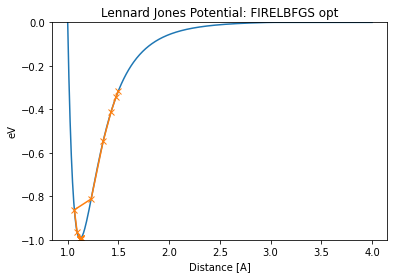

In [32]:
lennard_jones_trajectory(FIRELBFGS, 1.5)

           Step     Time          Energy         fmax
FIRELBFGS:    0 05:52:13       -0.697220        2.3246
FIRELBFGS:    1 05:52:13       -0.807702        2.3874
FIRELBFGS:    2 05:52:13       -0.987241        0.8220
FIRELBFGS:    3 05:52:13       -0.520102       13.5704
FIRELBFGS:    4 05:52:13       -0.971689        1.9036
FIRELBFGS:    5 05:52:13       -0.939109        1.8400
FIRELBFGS:    6 05:52:13       -0.943288        1.7937
FIRELBFGS:    7 05:52:13       -0.951214        1.6946
FIRELBFGS:    8 05:52:13       -0.961964        1.5294
FIRELBFGS:    9 05:52:13       -0.974030        1.2780
FIRELBFGS:   10 05:52:13       -0.985244        0.9149
FIRELBFGS:   11 05:52:13       -0.992867        0.4142
FIRELBFGS:   12 05:52:13       -0.994043        0.2396
FIRELBFGS:   13 05:52:13       -0.994061        0.2350
FIRELBFGS:   14 05:52:13       -0.994095        0.2259
FIRELBFGS:   15 05:52:13       -0.994143        0.2125
FIRELBFGS:   16 05:52:13       -0.994201        0.1951
FIRELBFGS: 

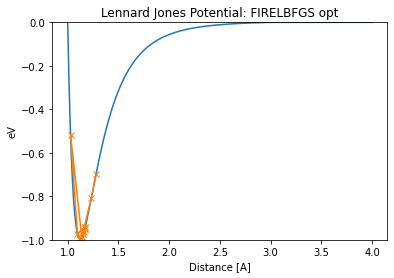

In [33]:
lennard_jones_trajectory(FIRELBFGS, 1.28)

## 更にきちんと学びたい方のために

以下書籍にニュートン法ファミリーや準ニュートン法、LineSearchなどの手法に関する詳細な解説があります。  

 - "Numerical Optimization" Jorge Nocedal, Stephan Wright https://doi.org/10.1007/978-0-387-40065-5

FIREは元論文を読むと理解しやすいでしょう。  

 - [Structural Relaxation Made Simple](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.170201)


また、どの手法もASEの実装を読むことで勉強することもできます。

In [34]:
from ase.optimize import FIRE
??FIRE

Init signature:
FIRE(
    atoms,
    restart=None,
    logfile='-',
    trajectory=None,
    dt=0.1,
    maxstep=None,
    maxmove=None,
    dtmax=1.0,
    Nmin=5,
    finc=1.1,
    fdec=0.5,
    astart=0.1,
    fa=0.99,
    a=0.1,
    master=None,
    downhill_check=False,
    position_reset_callback=None,
    force_consistent=None,
)
Docstring:      Base-class for all structure optimization classes.
Source:        
class FIRE(Optimizer):
    def __init__(self, atoms, restart=None, logfile='-', trajectory=None,
                 dt=0.1, maxstep=None, maxmove=None, dtmax=1.0, Nmin=5,
                 finc=1.1, fdec=0.5,
                 astart=0.1, fa=0.99, a=0.1, master=None, downhill_check=False,
                 position_reset_callback=None, force_consistent=None):
        """Parameters:

        atoms: Atoms object
            The Atoms object to relax.

        restart: string
            Pickle file used to store hessian matrix. If set, file with
            such a name will be se